In [ ]:
import pandas as pd

In [55]:
df = pd.read_csv("gephi_graphs/graph_data.csv")

In [56]:
from collections import Counter
from ast import literal_eval
counter = Counter()

df_summs = pd.read_csv('../../results/schembl_summs_v5_final.csv')
df_summs = df_summs['summarizations'].apply(literal_eval)
# count each label in summarizations
for i in range(len(df_summs)):
    counter.update(df_summs[i])

In [113]:
df["source_global_count"] = df['source'].apply(lambda x: counter[x])
df["target_global_count"] = df['target'].apply(lambda x: counter[x])

In [59]:
# label_of_interest = "hcv"
# print('head')
# print(df.loc[df["source"] == label_of_interest].loc[df["global_count"] < 2000].sort_values(by="weight", ascending=False).head(10)["target"].values)
# # print('tail')
# # print(df.loc[df["source"] == label_of_interest].loc[df["global_count"] < 2000].sort_values(by="weight", ascending=False).tail(10)["target"].values)

head


array(['antiviral', 'ns', 'compound', 'hepatitis', 'c', 'protease',
       'agent', 'replication', 'viral', 'polymerase'], dtype=object)

In [ ]:
# load in fingerprint data
# df_fp = pd.read_csv("../../results/schembl_summs_v5_final.csv")

In [ ]:
# df_fp["fingerprint"] = df_fp["smiles"].apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))

In [119]:
import random
from rdkit import Chem
import pandas as pd
from ast import literal_eval
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import plotly.express as px
import plotly.graph_objects as go


In [122]:
# df_fp.to_pickle("../../results/schembl_summs_v5_final_fp_bitvec.pkl")
df_fp = pd.read_pickle("../../results/schembl_summs_v5_final_fp_bitvec.pkl")
df_fp["summarizations"] = df_fp["summarizations"].apply(literal_eval)


In [123]:
tsne_df = pd.read_csv("./chef_v5_fp_tsne_p1000.csv")
tsne_df["summarizations"] = tsne_df["summarizations"].map(literal_eval)

Graph neighbors
Mean 0.911177311808743
Std 0.18262959898079115
95 conf 0.010064262926477862
Null
Mean 0.5381035451133606
Std 0.13955371562456625
95 conf 0.007690458141783914
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

null vs. graph: t-test independent samples, P_val:0.000e+00 t=-5.771e+01


<Figure size 640x480 with 0 Axes>

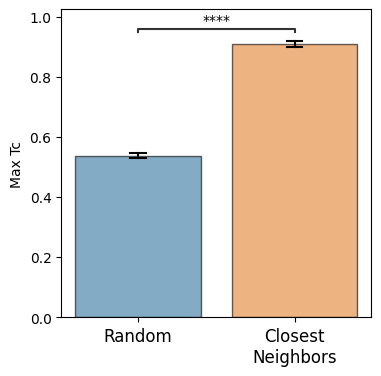

In [127]:
term_1 = 'electroluminescence'

# swap source and target if term_1 is in target. This ensures that term_1 is always in source
df.loc[df["target"] == term_1, ["target", "source"]] = df.loc[df["target"] == term_1, ["source", "target"]].values

# get 10 closest terms to term_1 that aren't very common
close_terms = df.loc[df["source"] == term_1].loc[df["target_global_count"] < 1000].sort_values(by="weight", ascending=False).head(10)["target"].values

# for each row in dataframe that contains term_1 in 'summarizations'
df_term_1 = df_fp[df_fp["summarizations"].map(lambda x: any(term_1 == word for word in x))].reset_index(drop=True)

# for each row in dataframe that contains any term in close_terms in 'summarizations'
df_close_terms = df_fp[df_fp["summarizations"].map(lambda x: any(term in x for term in close_terms))].reset_index(drop=True)

# choose a random 10 terms not found in close_terms or term_1
illegal_terms = close_terms + [term_1]

# sample from counter, ensuring that the term is not in illegal_terms and less than 2000 count
random.seed(hash(term_1))
rand_10_terms = random.sample([term for term in counter if term not in illegal_terms and counter[term] < 1000], 10)

df_random_terms = df_fp[df_fp["summarizations"].map(lambda x: any(term in x for term in rand_10_terms))].reset_index(drop=True)

# Compute mean distance from term_1 to the closest term in term_2
fp_tanimoto = np.zeros((len(df_term_1)))
for i in range(len(df_term_1)):
    sim = np.array(DataStructs.BulkTanimotoSimilarity(df_term_1['fingerprint'].iloc[i], df_close_terms['fingerprint']))
    
    # remove values if above 0.99
    # sim = sim[sim != 1.0]
    fp_tanimoto[i] = np.max(sim)

neighbor_mean = np.mean(fp_tanimoto)
neighbor_std = np.std(fp_tanimoto)
neighbor_conf = np.std(fp_tanimoto)*1.96/np.sqrt(len(fp_tanimoto))

print("Graph neighbors")
print("Mean", neighbor_mean)
print("Std", neighbor_std)
print("95 conf", neighbor_conf)



# null similarity
fp_tanimoto_null = np.zeros((len(df_term_1)))
for i in range(len(df_term_1)):
    sim = np.array(DataStructs.BulkTanimotoSimilarity(df_term_1['fingerprint'].iloc[i], df_random_terms['fingerprint']))

    fp_tanimoto_null[i] = np.max(sim)

random_mean = np.mean(fp_tanimoto_null)
random_std = np.std(fp_tanimoto_null)
random_conf = np.std(fp_tanimoto_null)*1.96/np.sqrt(len(fp_tanimoto_null))

print("Null")
print("Mean", random_mean)
print("Std", random_std)
print("95 conf", random_conf)

# clear plots
plt.clf()

plot_df = pd.DataFrame(columns=['group', 'value'])
plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'null', 'value': fp_tanimoto_null})])
plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'graph', 'value': fp_tanimoto})])


# make combined plot
fig, ax = plt.subplots(figsize=(4, 4))

# add first plot. Make conf interval have caps. Set confidence interval to 95% (variable)
sns.barplot(x='group', y='value', data=plot_df, color='white', ax=ax, palette=sns.color_palette(), dodge=False, alpha=0.6, ec='k', linewidth=1, capsize=0.1, errwidth=1.5, errcolor='k', errorbar=('ci', 95))

# remove xlabel
ax.set_xlabel('')
ax.set_ylabel(f'Max Tc')
# set x axis labels
ax.set_xticklabels([f'Random', f'Closest\nNeighbors'], fontsize=12)
ax.set_ylim(0, 0.5)

# prep data for statistical test
# add statistical annotations
annotator = Annotator(data=plot_df, x='group', y='value', pairs = [('null', 'graph')], ax=ax)
annotator.configure(test="t-test_ind", text_format='star', loc='inside', verbose=2)
# line up width with means of distributions
annotator.apply_test()
annotator.annotate()


plt.savefig(f'neighbors_max_tc_{term_1}.png', dpi=300, bbox_inches='tight')

# write close_terms, means, and stds to file
with open(f'neighbors_max_tc_{term_1}.txt', 'w') as f:
    f.write(f'Term: {term_1}\n')
    f.write(f'Close terms: {close_terms}\n')
    f.write(f'Mean: {neighbor_mean}\n')
    f.write(f'Std: {neighbor_std}\n')
    f.write(f'95% Conf: {neighbor_conf}\n')
    f.write(f'Random terms: {rand_10_terms}\n')
    f.write(f'Random mean: {random_mean}\n')
    f.write(f'Random std: {random_std}\n')
    f.write(f'Random 95% conf: {random_conf}\n')
    f.write(f"n_mols with term_1: {len(fp_tanimoto)}\n")
    f.write(f"n_mols with neighbor terms: {len(df_close_terms)}\n")
    f.write(f"n_mols with random terms: {len(df_random_terms)}\n")



# NOTE Plotly tsne plots

# ggplot2 colors
colors = [
    "#F8766D",
    "#7CAE00",
    "#00BFC4",
    "#C77CFF",
    "#C7C777",
    "#FFC90E",
    "#00B0F6",
    "#E76BF3",
    "#FF905C",
    "#00BE67",
]


fig = go.Figure(data=[
    go.Scattergl(
            x=tsne_df[f"fp_tsne_x"],
            y=tsne_df[f"fp_tsne_y"],
        mode="markers",
        marker=dict(
            opacity=0.1,
            color="#000000",
            size=2,
            line={"color": "#000000", "width":0.1}, # black
        ),
        hoverinfo="skip",
        name = "all"
    ),
])

for label, color in zip(close_terms, colors):
    fig.add_trace(
        go.Scattergl(
            x=tsne_df[tsne_df["summarizations"].map(lambda x: any(label == word for word in x))][f"fp_tsne_x"],
            y=tsne_df[tsne_df["summarizations"].map(lambda x: any(label == word for word in x))][f"fp_tsne_y"],
            mode="markers",
            marker=dict(
                opacity=0.3,
                color=color,
                size=5,
                line=dict(width=0.5, color='DarkSlateGrey'),
            ),
            hoverinfo="skip",
            # legend
            name=label,
        )
    )



# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,0.1)'
)

# make plot large square
fig.update_layout(
    width=1100,
    height=900,
    # autosize=False,
    margin=dict(l=0, r=0, b=0, t=0, pad=0),
    # dark theme
    template="ggplot2",

)

# remove legend of both traces
fig.update_layout(showlegend=True)

# hide axis and tick marks, and numbers
# fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
# fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
# increase font size of axis ticks
fig.update_xaxes(tickfont=dict(size=28))
fig.update_yaxes(tickfont=dict(size=28))

# save as png
fig.write_html(f"tsne_10_nearest_neighbors_{term_1}.html")

fig = go.Figure(data=[
    go.Scattergl(
            x=tsne_df[f"fp_tsne_x"],
            y=tsne_df[f"fp_tsne_y"],
        mode="markers",
        marker=dict(
            opacity=0.1,
            color="#000000",
            size=2,
            line={"color": "#000000", "width":0.1}, # black
        ),
        hoverinfo="skip",
        name = "all"
    ),
])

fig.add_trace(
    go.Scattergl(
        x=tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))][f"fp_tsne_x"],
        y=tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))][f"fp_tsne_y"],
        mode="markers",
        marker=dict(
            opacity=1,
            color="#F8766D",
            size=5,
            line=dict(width=0.5, color='DarkSlateGrey'),
        ),
        hoverinfo="skip",
        # legend
        name=term_1,
    )
)



# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,0.1)'
)

# make plot large square
fig.update_layout(
    width=1100,
    height=900,
    # autosize=False,
    margin=dict(l=0, r=0, b=0, t=0, pad=0),
    # dark theme
    template="ggplot2",

)

# remove legend of both traces
fig.update_layout(showlegend=True)

# hide axis and tick marks, and numbers
# fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
# fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, visible=False)
# increase font size of axis ticks
fig.update_xaxes(tickfont=dict(size=28))
fig.update_yaxes(tickfont=dict(size=28))

# save as png
fig.write_html(f"tsne_{term_1}.html")